In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from utility import Dataset, oh_encoder, l_encoder, scaler, get_best_features,  pca
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from utility import Dataset

columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
           'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
           'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
           'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
           'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
           'dst_host_srv_rerror_rate', 'label', 'score']

nominal_features = ['protocol_type', 'service', 'flag']
binary_features = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
numeric_features = [feature for feature in columns if feature not in nominal_features + binary_features + ['label', 'score', 'num_outbound_cmds']]

starting_train_df = pd.read_csv(f'dataset/nsl-kdd/KDDTrain+.txt', header=None)
starting_test_df = pd.read_csv(f'dataset/nsl-kdd/KDDTest+.txt', header=None)

# 2-labels

- Random Forest
- MinMaxScaler
- LabelEncoder
- Mutual Information (3 best features)

Index(['service', 'src_bytes', 'dst_bytes'], dtype='object')
              precision    recall  f1-score   support

      attack       0.90      0.81      0.86     12833
      normal       0.78      0.88      0.83      9711

    accuracy                           0.84     22544
   macro avg       0.84      0.85      0.84     22544
weighted avg       0.85      0.84      0.84     22544



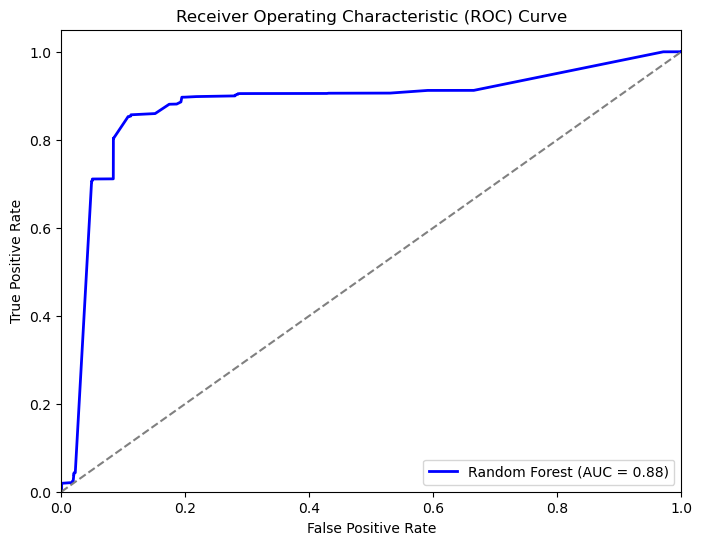

Random Forest AUC: 0.88


In [23]:
train_df = Dataset(starting_train_df, columns).get_label2()
test_df = Dataset(starting_test_df, columns).get_label2()

train_df, test_df = scaler(train_df, test_df, numeric_features, MinMaxScaler())
train_df, test_df = l_encoder(train_df, test_df, ['protocol_type', 'flag', 'service'])

X_train, X_test = get_best_features(train_df, test_df, mutual_info_classif, 3)
y_train = train_df['label']
y_test = test_df['label']

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=model.classes_))

y_test = y_test.apply(lambda x: 1 if x == 'normal' else -1)

y_probs_rf = model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f"Random Forest AUC: {roc_auc_rf:.2f}")

- Decision Tree
- MinMaxScaler
- OneHotEncoder
- PCA (11 best features)

(125973, 11)
[[ 1.97239503e-04  8.74210130e-07  4.01557696e-07 ...  5.18040870e-03
   4.65768541e-03  5.23857367e-03]
 [ 1.54281505e-02  5.11690574e-05  3.97206242e-05 ...  5.99110671e-04
   4.76683420e-04  4.21046280e-04]
 [ 1.73229208e-03 -1.61375042e-05 -6.04738304e-06 ... -1.82577431e-03
  -1.61857110e-03 -1.78752167e-03]
 ...
 [-1.28620489e-02 -1.68726649e-04 -4.13249379e-05 ...  3.49941342e-03
   3.17299655e-03  3.78124419e-03]
 [ 1.01647475e-01  9.47464437e-05  2.88092427e-04 ... -3.60109365e-03
  -3.36997673e-03 -3.35154323e-03]
 [ 1.41983161e-02  6.96847748e-06  4.49619234e-05 ...  3.83997429e-05
   3.95367487e-04  9.39443287e-05]]
[0.41252402 0.15651982 0.10942724 0.05073837 0.04106383 0.02822428
 0.02268929 0.01979969 0.01497984 0.01378681 0.0113418 ]
[1.74893431 0.66358048 0.46392705 0.21511009 0.17409395 0.11965947
 0.09619337 0.08394264 0.06350844 0.05845049 0.04808464]
[469.37911462 289.12378026 241.74742763 164.61423976 148.09106357
 122.77517341 110.08029591 102.832010

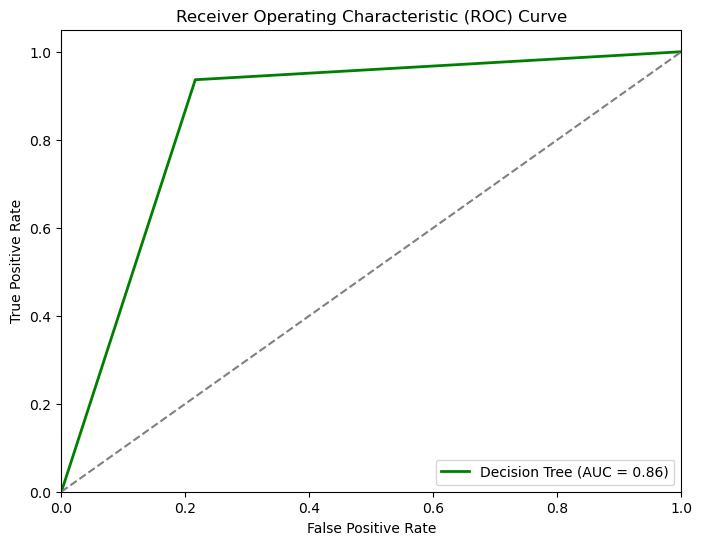

Decision Tree AUC: 0.86


In [24]:
train_df = Dataset(starting_train_df, columns).get_label2()
test_df = Dataset(starting_test_df, columns).get_label2()

train_df, test_df = scaler(train_df, test_df, numeric_features, MinMaxScaler())
train_df, test_df = oh_encoder(train_df, test_df, ['protocol_type', 'flag', 'service'])

X_train, X_test = pca(train_df, test_df, 11)
y_train = train_df['label']
y_test = test_df['label']

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=model.classes_))

y_test = y_test.apply(lambda x: 1 if x == 'normal' else -1)

y_probs_dt = model.predict_proba(X_test)[:, 1] 
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_probs_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f"Decision Tree AUC: {roc_auc_dt:.2f}")

- LinearSVC
- MinMaxScaler
- LabelEncoder
- PCA (24 best features)

(125973, 24)
[[ 3.45297056e-04  7.57325679e-04  9.98317694e-01 -5.13646222e-02
  -4.03940819e-07  6.78855127e-07 -8.45091622e-06  4.31206357e-04
   3.18522074e-06 -1.09987839e-04  1.82230398e-05 -4.33536735e-03
   3.84492769e-06  7.36088958e-05  1.76378090e-05  3.99820379e-06
   2.78686847e-05  1.62931673e-06  2.00354086e-05  8.47591045e-07
  -4.31670581e-04  1.42236619e-03 -2.27475262e-03  7.65165387e-03
   7.58162509e-03  3.01212546e-03  3.02649694e-03 -1.00949456e-02
   2.33717825e-03 -1.46321823e-03  4.65364506e-03 -1.09431510e-02
  -1.25608873e-02  3.29995281e-03 -2.12942033e-03 -1.07703551e-03
   7.76764670e-03  7.67340068e-03  2.92535775e-03  3.01052167e-03]
 [ 8.20641716e-04 -1.68184026e-02 -5.61541005e-02 -9.52448326e-01
   1.38085984e-05  3.54281023e-06  7.24043062e-05 -2.99579793e-03
  -1.75141430e-05 -5.21050707e-04 -1.84566260e-05 -1.09998312e-01
  -1.71675284e-05 -4.83095473e-04 -7.08543704e-05 -1.83189415e-05
  -1.25862833e-04 -6.42753595e-05 -1.72610155e-04 -4.00021748e

c:\Users\crist\miniconda3\envs\envTesi\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\crist\miniconda3\envs\envTesi\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

      attack       0.93      0.62      0.75     12833
      normal       0.65      0.93      0.77      9711

    accuracy                           0.76     22544
   macro avg       0.79      0.78      0.76     22544
weighted avg       0.81      0.76      0.76     22544



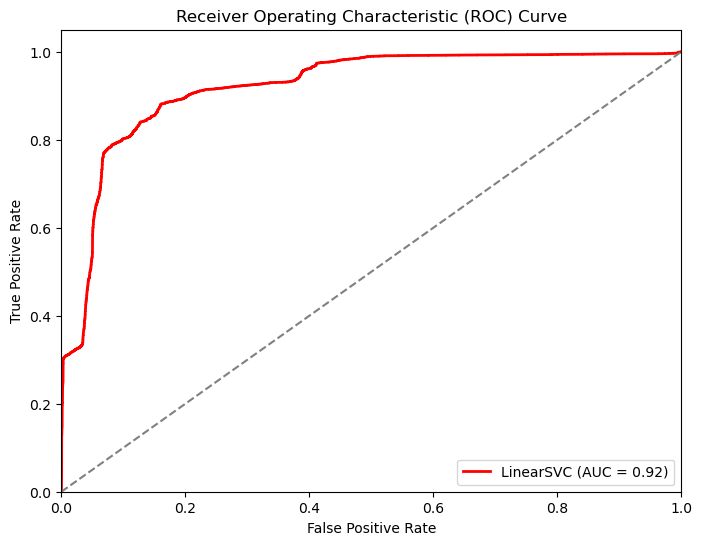

LinearSVC AUC: 0.92


In [21]:
train_df = Dataset(starting_train_df, columns).get_label2()
test_df = Dataset(starting_test_df, columns).get_label2()

train_df, test_df = scaler(train_df, test_df, numeric_features, MinMaxScaler())
train_df, test_df = l_encoder(train_df, test_df, ['protocol_type', 'flag', 'service'])

X_train, X_test = pca(train_df, test_df, 24)
y_train = train_df['label']
y_test = test_df['label']

model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=model.classes_))

y_test = y_test.apply(lambda x: 1 if x == 'normal' else -1)

y_scores_svc = model.decision_function(X_test) 
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_scores_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svc, tpr_svc, color='red', lw=2, label=f'LinearSVC (AUC = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f"LinearSVC AUC: {roc_auc_svc:.2f}")

# 5-labels

- Random Forest
- MinMaxScaler
- LabelEncoder
- PCA (11 best features)

(125973, 11)
[[ 3.45297056e-04  7.57325679e-04  9.98317694e-01 -5.13646222e-02
  -4.03940819e-07  6.78855127e-07 -8.45091622e-06  4.31206357e-04
   3.18522074e-06 -1.09987839e-04  1.82230398e-05 -4.33536735e-03
   3.84492769e-06  7.36088958e-05  1.76378090e-05  3.99820379e-06
   2.78686847e-05  1.62931673e-06  2.00354086e-05  8.47591045e-07
  -4.31670581e-04  1.42236619e-03 -2.27475262e-03  7.65165387e-03
   7.58162509e-03  3.01212546e-03  3.02649694e-03 -1.00949456e-02
   2.33717825e-03 -1.46321823e-03  4.65364506e-03 -1.09431510e-02
  -1.25608873e-02  3.29995281e-03 -2.12942033e-03 -1.07703551e-03
   7.76764670e-03  7.67340068e-03  2.92535775e-03  3.01052167e-03]
 [ 8.20641716e-04 -1.68184026e-02 -5.61541005e-02 -9.52448326e-01
   1.38085984e-05  3.54281023e-06  7.24043062e-05 -2.99579793e-03
  -1.75141430e-05 -5.21050707e-04 -1.84566260e-05 -1.09998312e-01
  -1.71675284e-05 -4.83095473e-04 -7.08543704e-05 -1.83189415e-05
  -1.25862833e-04 -6.42753595e-05 -1.72610155e-04 -4.00021748e

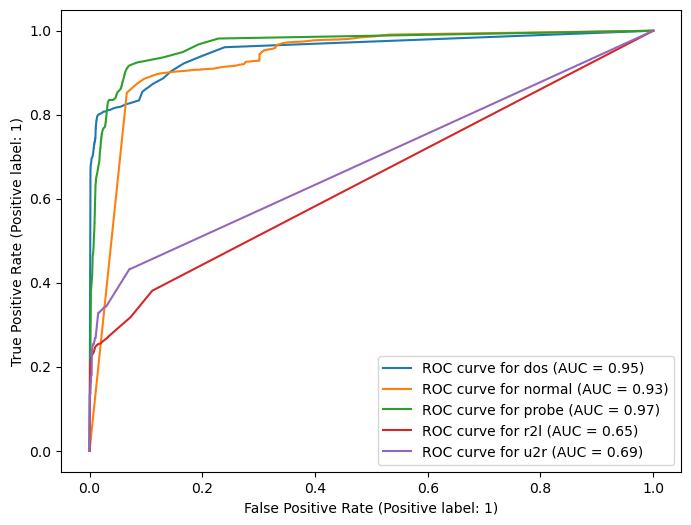

In [25]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score
train_df = Dataset(starting_train_df, columns).get_label5()
test_df = Dataset(starting_test_df, columns).get_label5()

train_df, test_df = scaler(train_df, test_df, numeric_features, MinMaxScaler())
train_df, test_df = l_encoder(train_df, test_df, ['protocol_type', 'flag', 'service'])

X_train, X_test = pca(train_df, test_df, 11)
y_train = train_df['label']
y_test = test_df['label']

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=model.classes_))

y_test_new = label_binarize(y_test, classes=model.classes_)
prob_test = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
threshold = dict()
auc_score = dict()
for i in range(5):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_new[:, i], prob_test[:, i])
    auc_score[i] = roc_auc_score(y_test_new[:, i], prob_test[:, i])

fig, ax = plt.subplots(figsize=(8, 6))
target_names = model.classes_
for class_id in range(5):
    RocCurveDisplay.from_predictions(
        y_test_new[:, class_id],
        prob_test[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        ax=ax,
    )
    print("AUC: ", auc_score[class_id])

- Decision Tree
- MinMaxScaler
- OneHotEncoder
- PCA (18 best features)

decision tree, scalato, ohe, pca, 18 best feature (0.80)
(125973, 18)
[[ 1.97239503e-04  8.74210130e-07  4.01557696e-07 ...  5.18040870e-03
   4.65768541e-03  5.23857367e-03]
 [ 1.54281505e-02  5.11690574e-05  3.97206242e-05 ...  5.99110653e-04
   4.76683404e-04  4.21046285e-04]
 [ 1.73229207e-03 -1.61375041e-05 -6.04738312e-06 ... -1.82577407e-03
  -1.61857112e-03 -1.78752151e-03]
 ...
 [-2.30020866e-02 -1.45186795e-04 -5.18724339e-05 ...  8.90511385e-03
   6.08715268e-03  6.60972934e-03]
 [-5.41400483e-04 -2.00753055e-04 -5.02770217e-05 ... -7.47931878e-03
  -3.80845453e-03 -6.03439682e-03]
 [-2.96113162e-02  4.75497365e-04 -1.12692707e-04 ... -2.07153222e-02
  -2.12047217e-02 -2.27394028e-02]]
[0.41252402 0.15651982 0.10942724 0.05073837 0.04106383 0.02822428
 0.02268929 0.01979969 0.01497984 0.01378681 0.0113418  0.00974557
 0.00676199 0.00657087 0.00628032 0.00543983 0.00450265 0.00407848]
[1.74893431 0.66358048 0.46392705 0.21511009 0.17409395 0.11965947
 0.09619337 0.08394264 0.

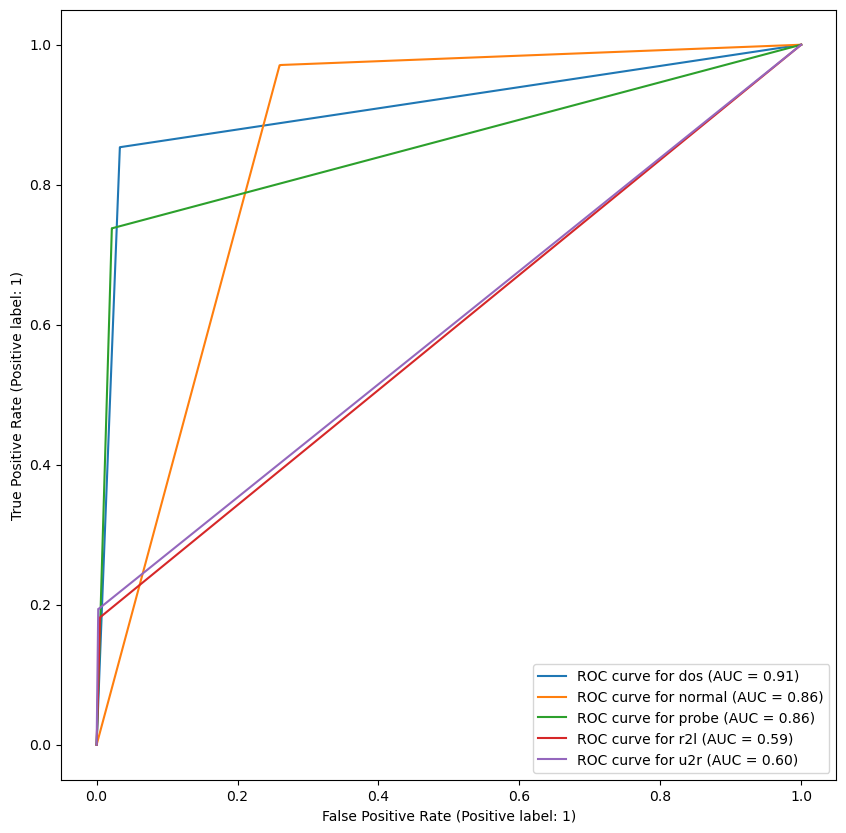

In [36]:
train_df = Dataset(starting_train_df, columns).get_label5()
test_df = Dataset(starting_test_df, columns).get_label5()

train_df, test_df = scaler(train_df, test_df, numeric_features, MinMaxScaler())
train_df, test_df = oh_encoder(train_df, test_df, ['protocol_type', 'flag', 'service'])

X_train, X_test = pca(train_df, test_df, 18)
y_train = train_df['label']
y_test = test_df['label']

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=model.classes_))

y_test_new = label_binarize(y_test, classes=model.classes_)
prob_test = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
threshold = dict()
auc_score = dict()
for i in range(5):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_new[:, i], prob_test[:, i])
    auc_score[i] = roc_auc_score(y_test_new[:, i], prob_test[:, i])

fig, ax = plt.subplots(figsize=(8, 6))
target_names = model.classes_
for class_id in range(5):
    RocCurveDisplay.from_predictions(
        y_test_new[:, class_id],
        prob_test[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        ax=ax,
    )
    print("AUC: ", auc_score[class_id])

- LinearSVC
- MinMaxScaler
- LabelEncoder
- PCA (15 best feature)

(125973, 15)
[[ 3.45297056e-04  7.57325679e-04  9.98317694e-01 -5.13646222e-02
  -4.03940819e-07  6.78855127e-07 -8.45091622e-06  4.31206357e-04
   3.18522074e-06 -1.09987839e-04  1.82230398e-05 -4.33536735e-03
   3.84492769e-06  7.36088958e-05  1.76378090e-05  3.99820379e-06
   2.78686847e-05  1.62931673e-06  2.00354086e-05  8.47591045e-07
  -4.31670581e-04  1.42236619e-03 -2.27475262e-03  7.65165387e-03
   7.58162509e-03  3.01212546e-03  3.02649694e-03 -1.00949456e-02
   2.33717825e-03 -1.46321823e-03  4.65364506e-03 -1.09431510e-02
  -1.25608873e-02  3.29995281e-03 -2.12942033e-03 -1.07703551e-03
   7.76764670e-03  7.67340068e-03  2.92535775e-03  3.01052167e-03]
 [ 8.20641716e-04 -1.68184026e-02 -5.61541005e-02 -9.52448326e-01
   1.38085984e-05  3.54281023e-06  7.24043062e-05 -2.99579793e-03
  -1.75141430e-05 -5.21050707e-04 -1.84566260e-05 -1.09998312e-01
  -1.71675284e-05 -4.83095473e-04 -7.08543704e-05 -1.83189415e-05
  -1.25862833e-04 -6.42753595e-05 -1.72610155e-04 -4.00021748e

c:\Users\crist\miniconda3\envs\envTesi\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\crist\miniconda3\envs\envTesi\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\crist\miniconda3\envs\envTesi\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\crist\miniconda3\envs\envTesi\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division

              precision    recall  f1-score   support

         dos       0.91      0.78      0.84      7460
      normal       0.65      0.94      0.77      9711
       probe       0.84      0.78      0.81      2421
         r2l       0.30      0.00      0.00      2885
         u2r       0.00      0.00      0.00        67

    accuracy                           0.75     22544
   macro avg       0.54      0.50      0.49     22544
weighted avg       0.71      0.75      0.70     22544

AUC:  0.9393689352139191
AUC:  0.9282944997917411
AUC:  0.9723998524317086
AUC:  0.8253272014008693
AUC:  0.851436858506772


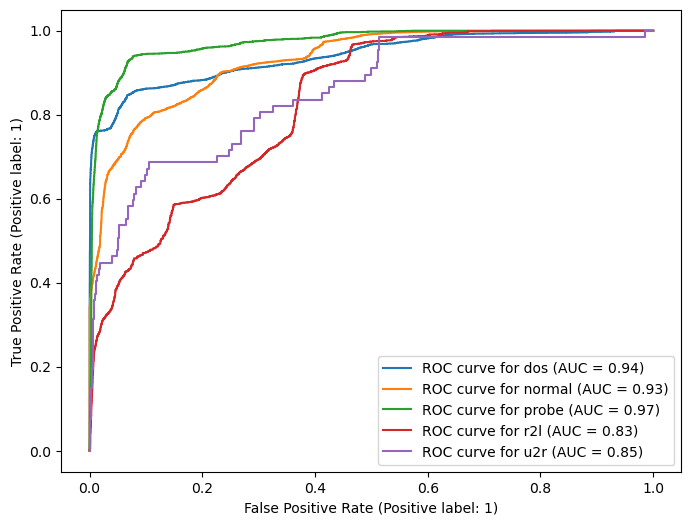

In [26]:
train_df = Dataset(starting_train_df, columns).get_label5()
test_df = Dataset(starting_test_df, columns).get_label5()

train_df, test_df = scaler(train_df, test_df, numeric_features, MinMaxScaler())
train_df, test_df = l_encoder(train_df, test_df, ['protocol_type', 'flag', 'service'])

X_train, X_test = pca(train_df, test_df, 15)
y_train = train_df['label']
y_test = test_df['label']

model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=model.classes_))

y_test_new = label_binarize(y_test, classes=model.classes_)
prob_test = model.decision_function(X_test)

fpr = dict()
tpr = dict()
threshold = dict()
auc_score = dict()
for i in range(5):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_new[:, i], prob_test[:, i])
    auc_score[i] = roc_auc_score(y_test_new[:, i], prob_test[:, i])

fig, ax = plt.subplots(figsize=(8, 6))
target_names = model.classes_
for class_id in range(5):
    RocCurveDisplay.from_predictions(
        y_test_new[:, class_id],
        prob_test[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        ax=ax,
    )
    print("AUC: ", auc_score[class_id])